In [1]:
import os
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import albumentations as A
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append("../")
from src.datasets import SegmentationDataset

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Load the dataset
---

In [4]:
image_dir = '../Datasets/Intel_Image_Classification'
annotation_dir = '../Datasets/Intel_Image_Classification/annotations'

train_image_dir = f"{image_dir}/seg_train/seg_train"
train_anno_dir = f"{annotation_dir}/train"

test_image_dir = f"{image_dir}/seg_test/seg_test"
test_anno_dir = f"{annotation_dir}/test"

In [5]:
from albumentations.pytorch.transforms import ToTensorV2

In [6]:
IIC_MEAN, IIC_STD = (0.4396, 0.4655, 0.4589), (0.2016, 0.1988, 0.2019)

In [7]:
train_transforms = A.Compose([
    A.Resize(height=128, width=128),
    A.Normalize(mean=IIC_MEAN, std=IIC_STD),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(height=128, width=128),
    A.Normalize(mean=IIC_MEAN, std=IIC_STD),
    ToTensorV2()
])

In [8]:
train_dataset = SegmentationDataset(train_image_dir, train_anno_dir, train_transforms)
test_dataset = SegmentationDataset(test_image_dir, test_anno_dir, test_transforms)

In [9]:
from torch.utils.data import DataLoader

In [10]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

### Load model
---

In [11]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [12]:
num_classes = 40

In [13]:
model = deeplabv3_mobilenet_v3_large(
    pretrained=False, 
    pretrained_backbone=True,
    num_classes=num_classes
)

model = model.to(device)

In [21]:
!ls checkpoints/cross_entropy/twins/momentum/DeepLabV3MobileNetV3_large/

best.pt  last.pt


In [22]:
checkpoint_path = 'checkpoints/cross_entropy/twins/momentum/DeepLabV3MobileNetV3_large/best.pt'
model.load_state_dict(torch.load(checkpoint_path)['model_state_dict'])
# put to evaluation mode
model.eval();

### Define visualization tools
---

In [23]:
def get_random_colors(n_colors):
    return np.random.randint(low=0, high=256, size=(n_colors, 3))

def tensor_to_image(x, mean=IIC_MEAN, std=IIC_STD):
    x = x.permute(1, 2, 0).cpu().numpy()
    x = x * np.array(std).reshape(1, 1, 3) + np.array(mean).reshape(1, 1, 3)
    x = np.clip(x, 0, 1)
    return x

In [24]:
class MaskVisualizer:
    
    def __init__(self, n_classes : int, figsize=(6, 6)):
        self.n_classes = n_classes
        self.figsize = figsize
        # init random colors
        self.colors = get_random_colors(n_classes)
        
    def draw(self, image, gt_mask, pr_mask):
        nrows, ncols = 1, 3
        h, w = self.figsize
        
        fig, ax = plt.subplots(nrows, ncols, figsize=(h * ncols, w * nrows))

        ax[0].imshow(image)
        ax[0].set_title("Original image", fontsize=18)
        
        ax[1].imshow(self.colors[gt_mask])
        ax[1].set_title("True mask", fontsize=18)

        ax[2].imshow(self.colors[pr_mask])
        ax[2].set_title("Pred mask", fontsize=18)
        
        for i in range(3):
            ax[i].axis('off')
            
        plt.tight_layout()

In [25]:
mask_vis = MaskVisualizer(num_classes)

### Visualize predictions of the model
---

In [41]:
# generate random index or choose some
# image_id = np.random.randint(0, len(train_dataset))
image_id = 1877
print(f"Processing image with id {image_id} from train_dataset")
image, mask = train_dataset[image_id]
# put to device
images = image[None, ...].to(device)

Processing image with id 1877 from train_dataset


In [42]:
# predict
with torch.no_grad():
    mask_logits = model(images.to(device))['out']
# predict mask from logits
pred_mask = mask_logits.argmax(dim=1)
pred_mask = pred_mask.cpu().numpy()
# transform predictions
image_np = tensor_to_image(image)
pred_mask_np = pred_mask[0]
mask_np = mask.numpy().astype(np.uint8)

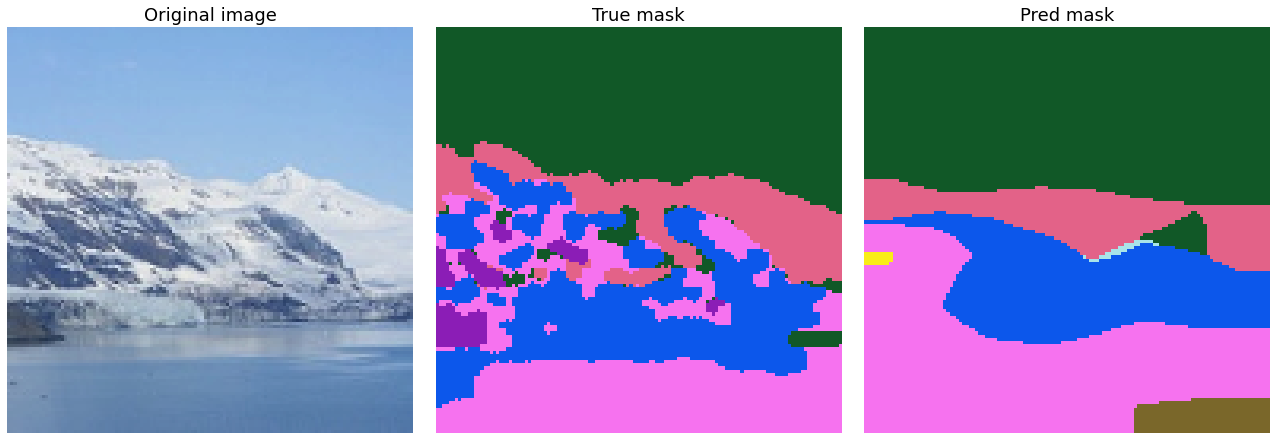

In [43]:
mask_vis.draw(image_np, mask_np, pred_mask_np)